# Library Import

In [1]:
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error, r2_score)
import matplotlib.pyplot as plt

# Load Data

t: time  
f: failures  
cum_f: cumulative failures

In [2]:
data = np.loadtxt('J1.csv', delimiter=',', skiprows=1, dtype=int)
data = np.insert(data, 0, [0, 0, 0], axis=0)

In [3]:
t = data[:, 0]
f = data[:, 1]
cum_f = data[:, 2]

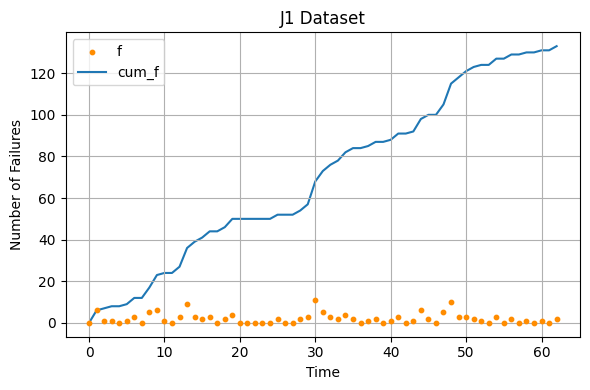

In [4]:
plt.figure(figsize=(6, 4))

plt.scatter(t, f, color='darkorange', s=10, label='f', zorder=2)
plt.plot(t, cum_f, label='cum_f', zorder=1)

plt.title('J1 Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

# Estimation

Preparation functions for parameter estimation

In [5]:
tiny = np.finfo(float).tiny  # Prevent log calculation errors (avoid log(0))


# Weibull model function
def weibull(t, a, b, c):
    return a * (1 - np.exp(-b * t**c))


# Residual function for LSM estimation using Weibull model
def weibull_lsm(params, t, cum_f):
    a, b, c = params
    return weibull(t, a, b, c) - cum_f


# Function to estimate parameter 'a' of the Weibull model
def weibull_a(t, f, b, c):
    a = f / (1 - np.exp(-b * t**c))
    return a


# Negative log-likelihood function for the Weibull model
def weibull_nll(params, t, f):
    b, c = params
    a = np.sum(f) / (1 - np.exp(-b * t[-1]**c))

    term1 = a * (np.exp(-b * t[:-1]**c) - np.exp(-b * t[1:]**c))
    term1[term1 < tiny] = tiny
    log_term1 = f[1:] * np.log(term1)

    term2 = a * (np.exp(-b * t[0]**c) - np.exp(-b * t[-1]**c))

    log_facs = [np.sum([np.log(j) for j in range(1, i+1)]) for i in f[1:]]

    loglikelihood = np.sum(log_term1) - term2 - np.sum(log_facs)
    return -loglikelihood

Setup variables for parameter estimation

In [6]:
eps = np.sqrt(np.finfo(float).eps)  # Small epsilon to avoid division by zero

# Parameter initialization and bounds for LSM estimation
lsm_init_guess = [cum_f[-1] * 1.5, 0.1, 1]
lsm_bounds = ([cum_f[-1], eps, 0], [np.inf, np.inf, 10])

# Parameter initialization and bounds for MLE estimation
mle_init_guess = [0.1, 1]
mle_bounds = [(eps, np.inf), (0, 10)]

## LSM

### Trust Region Reflective algorithm

In [7]:
result = least_squares(weibull_lsm, lsm_init_guess, args=(t, cum_f),
                       method='trf', bounds=lsm_bounds)

trf_a, trf_b, trf_c = result.x
print(f'a: {trf_a}, b: {trf_b}, c: {trf_c}')

a: 7479.084761258814, b: 0.0003298148200578028, c: 0.9799381532939042


In [8]:
f_pred = weibull(t, trf_a, trf_b, trf_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 20.838459443734866
RMSE: 4.564916148598446
MAE: 3.8007761416027175
MAPE: 0.08797205863526343
R2 score: 0.9875496730658312


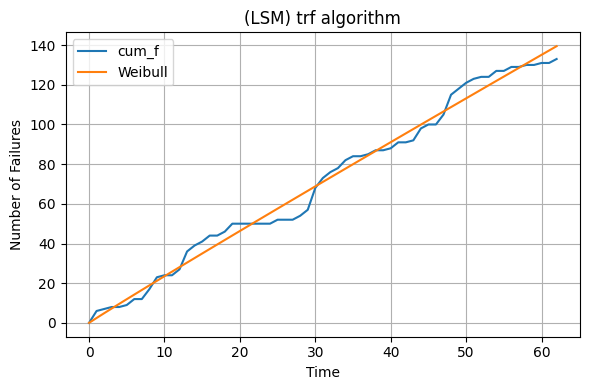

In [9]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(LSM) trf algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### dogleg algorithm

In [10]:
result = least_squares(weibull_lsm, lsm_init_guess, args=(t, cum_f),
                       method='dogbox', bounds=lsm_bounds)

dogbox_a, dogbox_b, dogbox_c = result.x
print(f'a: {dogbox_a}, b: {dogbox_b}, c: {dogbox_c}')

a: 446440.3970740285, b: 2.2120074091579085e-05, c: 0.6049053400199739


In [11]:
f_pred = weibull(t, dogbox_a, dogbox_b, dogbox_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 156.7965315588778
RMSE: 12.521842179123558
MAE: 10.903387480146886
MAPE: 0.3339397359298348
R2 score: 0.9063189826809068


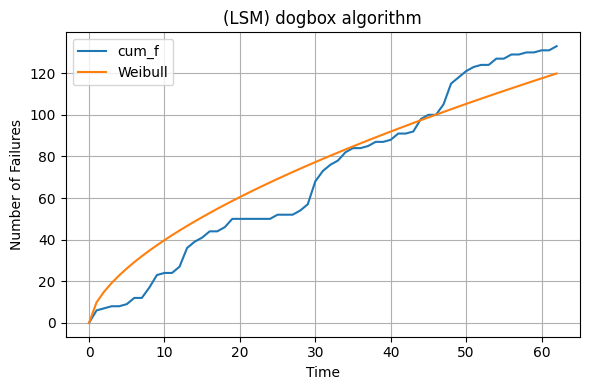

In [12]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(LSM) dogbox algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

## MLE

### Nelder-Mead algorithm

In [13]:
result = minimize(weibull_nll, mle_init_guess, args=(t, f),
                  method='Nelder-Mead', bounds=mle_bounds)

nelder_mead_b, nelder_mead_c = result.x
nelder_mead_a = weibull_a(t[-1], np.sum(f), nelder_mead_b, nelder_mead_c)
print(f'a: {nelder_mead_a}, b: {nelder_mead_b}, c: {nelder_mead_c}')

a: 224360953.9833566, b: 1.4901161193847656e-08, c: 0.8924859384074788


In [14]:
f_pred = weibull(t, nelder_mead_a, nelder_mead_b, nelder_mead_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.786715971508322
RMSE: 5.3653253369677705
MAE: 4.168547572095818
MAPE: 0.10056133893098751
R2 score: 0.9828008387004783


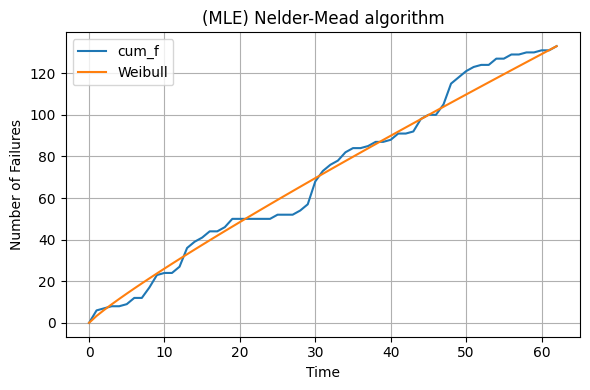

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(MLE) Nelder-Mead algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Powell algorithm

In [16]:
result = minimize(weibull_nll, mle_init_guess, args=(t, f),
                  method='Powell', bounds=mle_bounds)

powell_b, powell_c = result.x
powell_a = weibull_a(t[-1], np.sum(f), powell_b, powell_c)
print(f'a: {powell_a}, b: {powell_b}, c: {powell_c}')

a: 595.7293918559803, b: 0.0048426342135771275, c: 0.958176450373934


In [17]:
f_pred = weibull(t, powell_a, powell_b, powell_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 27.695352149423407
RMSE: 5.262637375824351
MAE: 4.051485476622434
MAPE: 0.09616943012710953
R2 score: 0.9834528944066964


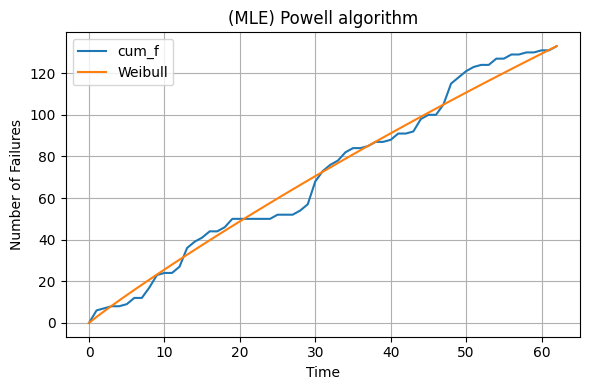

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(MLE) Powell algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### L-BFGS-B algorithm

In [19]:
result = minimize(weibull_nll, mle_init_guess, args=(t, f),
                  method='L-BFGS-B', bounds=mle_bounds)

l_bfgs_b_b, l_bfgs_b_c = result.x
l_bfgs_b_a = weibull_a(t[-1], np.sum(f), l_bfgs_b_b, l_bfgs_b_c)
print(f'a: {l_bfgs_b_a}, b: {l_bfgs_b_b}, c: {l_bfgs_b_c}')

a: 794.2016806070218, b: 0.0038320031735975036, c: 0.9371197912750694


In [20]:
f_pred = weibull(t, l_bfgs_b_a, l_bfgs_b_b, l_bfgs_b_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.093893412953495
RMSE: 5.300367290382195
MAE: 4.087173642727951
MAPE: 0.09824421709568057
R2 score: 0.9832147784825752


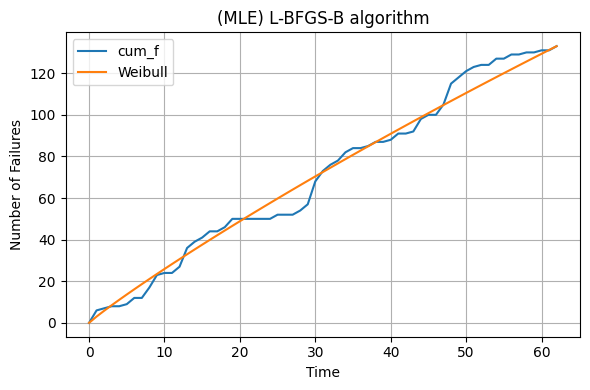

In [21]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(MLE) L-BFGS-B algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### truncated Newton (TNC) algorithm

In [22]:
result = minimize(weibull_nll, mle_init_guess, args=(t, f),
                  method='TNC', bounds=mle_bounds)

tnc_b, tnc_c = result.x
tnc_a = weibull_a(t[-1], np.sum(f), tnc_b, tnc_c)
print(f'a: {tnc_a}, b: {tnc_b}, c: {tnc_c}')

a: 668.7178769654789, b: 0.004400425690765111, c: 0.9497800812510002


In [23]:
f_pred = weibull(t, tnc_a, tnc_b, tnc_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 27.789695432777787
RMSE: 5.2715932537305825
MAE: 4.0622962356859516
MAPE: 0.09676322867101257
R2 score: 0.9833965272493748


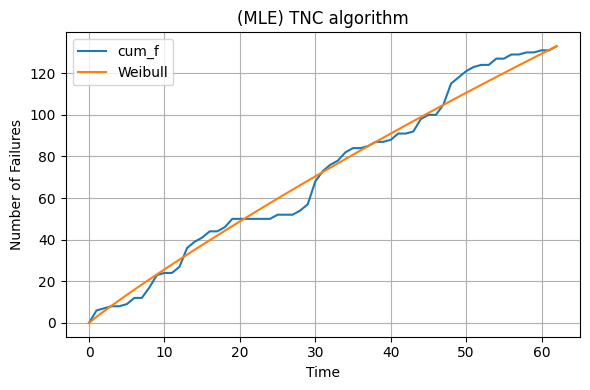

In [24]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(MLE) TNC algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Optimization BY Quadratic Approximations (COBYQA) algorithm

In [25]:
result = minimize(weibull_nll, mle_init_guess, args=(t, f),
                  method='COBYQA', bounds=mle_bounds)

cobyqa_b, cobyqa_c = result.x
cobyqa_a = weibull_a(t[-1], np.sum(f), cobyqa_b, cobyqa_c)
print(f'a: {cobyqa_a}, b: {cobyqa_b}, c: {cobyqa_c}')

a: 794.269713616759, b: 0.003831714169261756, c: 0.9371152872689363


In [26]:
f_pred = weibull(t, cobyqa_a, cobyqa_b, cobyqa_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.09394537566772
RMSE: 5.300372192183085
MAE: 4.087181790552671
MAPE: 0.09824452694218279
R2 score: 0.9832147474364807


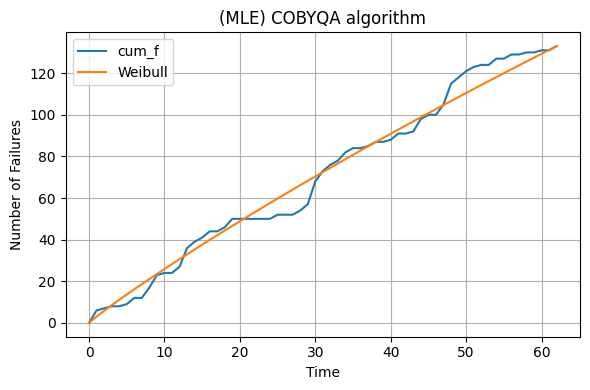

In [27]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(MLE) COBYQA algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Sequential Least Squares Programming (SLSQP)

In [28]:
result = minimize(weibull_nll, mle_init_guess, args=(t, f),
                  method='SLSQP', bounds=mle_bounds)

slsqp_b, slsqp_c = result.x
slsqp_a = weibull_a(t[-1], np.sum(f), slsqp_b, slsqp_c)
print(f'a: {slsqp_a}, b: {slsqp_b}, c: {slsqp_c}')

a: 794.258900349288, b: 0.003830765176939868, c: 0.9371789246468493


In [29]:
f_pred = weibull(t, slsqp_a, slsqp_b, slsqp_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.089085676400252
RMSE: 5.299913742354705
MAE: 4.087019872324751
MAPE: 0.09822523660490518
R2 score: 0.9832176509546052


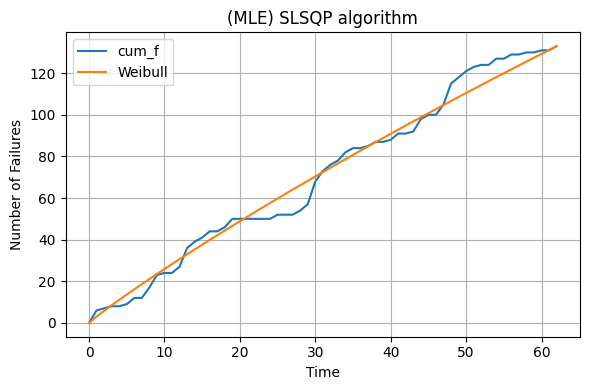

In [30]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(MLE) SLSQP algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()

### Constrained Trust-Region algorithm

In [31]:
result = minimize(weibull_nll, mle_init_guess, args=(t, f),
                  method='trust-constr', bounds=mle_bounds)

trust_constr_b, trust_constr_c = result.x
trust_constr_a = weibull_a(t[-1], np.sum(f), trust_constr_b, trust_constr_c)
print(f'a: {trust_constr_a}, b: {trust_constr_b}, c: {trust_constr_c}')

a: 794.2588751142164, b: 0.0038317654713055154, c: 0.9371156719597751


In [32]:
f_pred = weibull(t, trust_constr_a, trust_constr_b, trust_constr_c)

print(f'MSE: {mean_squared_error(cum_f, f_pred)}')
print(f'RMSE: {root_mean_squared_error(cum_f, f_pred)}')
print(f'MAE: {mean_absolute_error(cum_f, f_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(cum_f, f_pred)}')
print(f'R2 score: {r2_score(cum_f, f_pred)}')

MSE: 28.093962790127435
RMSE: 5.300373834941025
MAE: 4.087181342233676
MAPE: 0.09824457935740487
R2 score: 0.9832147370318864


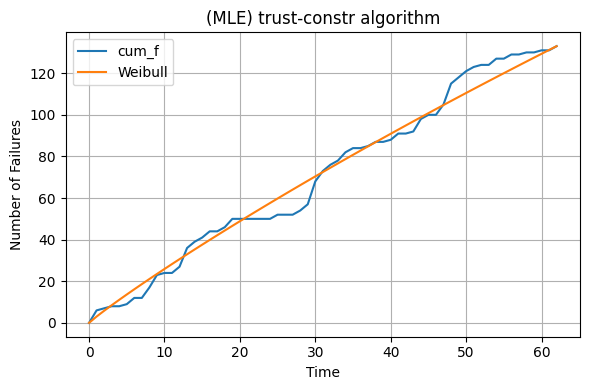

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(t, cum_f, label='cum_f')
plt.plot(t, f_pred, label='Weibull')

plt.title('(MLE) trust-constr algorithm')
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()